In [1]:
from auditory_cortex.plotters.plotter_utils import PlotterUtils
from auditory_cortex.plotters.correlation_plotter import RegPlotter
from auditory_cortex.analyses import Correlations
from auditory_cortex.models import Regression
from auditory_cortex.neural_data.neural_meta_data import NeuralMetaData
from auditory_cortex.dataloader import DataLoader

import torch
import numpy as np
import seaborn as sns
import scipy

import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
dataloader = DataLoader()
model_name = 'deepspeech2'
dnn_obj = dataloader.get_DNN_obj(model_name)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.p

Model on device: cuda


In [3]:
dnn_obj.layer_names

['conv.seq_module.2',
 'conv.seq_module.5',
 'rnns.0.rnn',
 'rnns.1.rnn',
 'rnns.2.rnn',
 'rnns.3.rnn',
 'rnns.4.rnn']

In [10]:
layers_with_weights = [
    'conv.seq_module.0.weight',
    'conv.seq_module.3.weight',
    'rnns.0.rnn.weight_ih_l0',
    # 'rnns.0.rnn.weight_hh_l0',
    'rnns.1.rnn.weight_ih_l0',
    'rnns.2.rnn.weight_ih_l0',
    'rnns.3.rnn.weight_ih_l0',
    'rnns.4.rnn.weight_ih_l0',
    'fc.0.module.0.weight',
]


Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.p

Model on device: cuda
Randomly 'resetting' the network parameters...


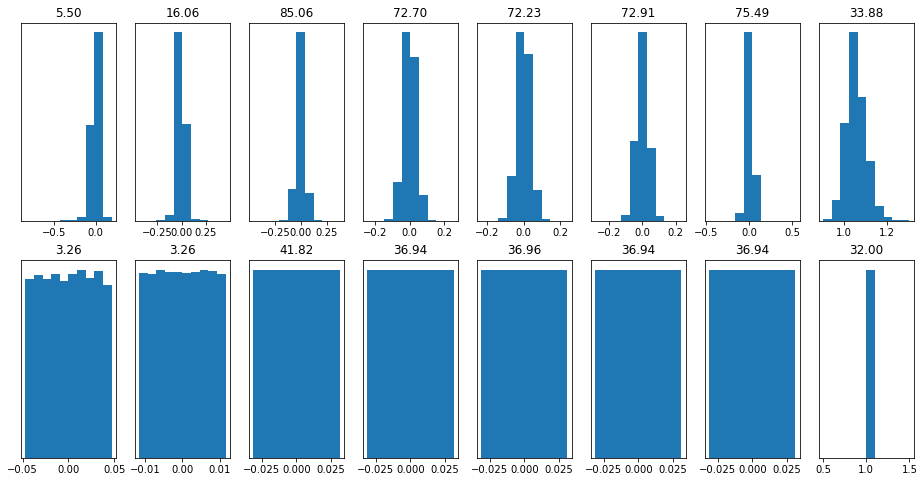

In [21]:
dataloader = DataLoader()
model_name = 'deepspeech2'
dnn_obj = dataloader.get_DNN_obj(model_name)

num_layers = len(layers_with_weights)
fig, axes = plt.subplots(nrows=2, ncols=num_layers, figsize=(16,8))

i = 0
for j, layer_name in enumerate(layers_with_weights):
    weights = dnn_obj.extractor.model.state_dict()[layer_name].flatten().cpu().numpy()
    norm = np.linalg.norm(weights)

    ax = axes[i, j]
    ax.hist(weights)
    ax.set_title(f"{norm:.2f}")
    ax.set_yticks([])

# reset weights..
out = dnn_obj.reset_model_parameters()
i = 1
for j, layer_name in enumerate(layers_with_weights):
    weights = dnn_obj.extractor.model.state_dict()[layer_name].flatten().cpu().numpy()
    norm = np.linalg.norm(weights)

    ax = axes[i, j]
    ax.hist(weights)
    ax.set_title(f"{norm:.2f}")
    ax.set_yticks([])

In [4]:
dict([*dnn_obj.extractor.model.named_modules()])

{'': DeepSpeech(
   (conv): MaskConv(
     (seq_module): Sequential(
       (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5))
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): Hardtanh(min_val=0, max_val=20, inplace=True)
       (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5))
       (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (5): Hardtanh(min_val=0, max_val=20, inplace=True)
     )
   )
   (rnns): Sequential(
     (0): BatchRNN(
       (rnn): LSTM(1312, 1024, bidirectional=True)
     )
     (1): BatchRNN(
       (batch_norm): SequenceWise (
       BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
       (rnn): LSTM(1024, 1024, bidirectional=True)
     )
     (2): BatchRNN(
       (batch_norm): SequenceWise (
       BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
       

In [65]:
def compare_weight_initializations(model_name, layer_name):
    dataloader = DataLoader()
    dnn_obj = dataloader.get_DNN_obj(model_name)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

    # layer_name = 'conv.seq_module.0.weight'

    weights = dnn_obj.extractor.model.state_dict()[layer_name].flatten().cpu().numpy()
    norm = np.linalg.norm(weights)

    i=0
    ax = axes[i//2, i%2]
    ax.hist(weights)
    ax.set_title(f"original Norm={norm:.2f}")

    # reset weights..
    out = dnn_obj.reset_model_parameters()
    weights = dnn_obj.extractor.model.state_dict()[layer_name].flatten().cpu().numpy()
    norm = np.linalg.norm(weights)

    i=1
    ax = axes[i//2, i%2]
    ax.hist(weights)
    ax.set_title(f"reset Norm={norm:.2f}")

    # randn weights..
    out = dnn_obj.randomly_reinitialize_weights(False)
    weights = dnn_obj.extractor.model.state_dict()[layer_name].flatten().cpu().numpy()
    norm = np.linalg.norm(weights)

    i=2
    ax = axes[i//2, i%2]
    ax.hist(weights)
    ax.set_title(f"randn Norm={norm:.2f}")

    # rand weights..
    out = dnn_obj.randomly_reinitialize_weights(True)
    weights = dnn_obj.extractor.model.state_dict()[layer_name].flatten().cpu().numpy()
    norm = np.linalg.norm(weights)

    i=3
    ax = axes[i//2, i%2]
    ax.hist(weights)
    ax.set_title(f"rand Norm={norm:.2f}")

    plt.suptitle(layer_name)

    

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.p

Randomly 'resetting' the network parameters...
Initializing 'random weights' the network parameters...
Initializing 'random weights' the network parameters...


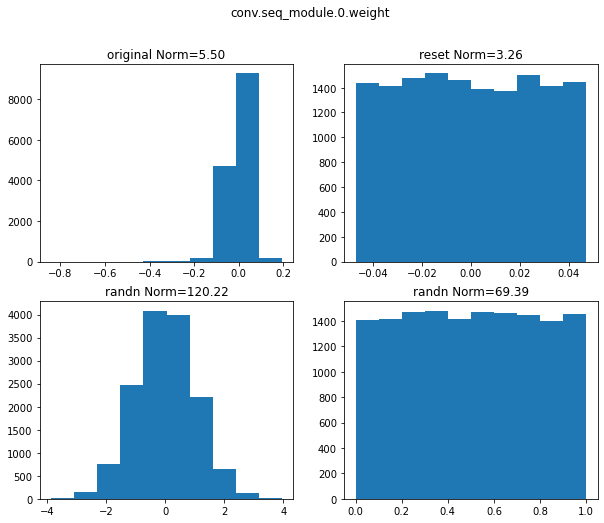

In [58]:
model_name = 'deepspeech2'
layer_name = 'conv.seq_module.0.weight'
compare_weight_initializations(model_name, layer_name)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.p

Randomly 'resetting' the network parameters...
Initializing 'random weights' the network parameters...
Initializing 'random weights' the network parameters...


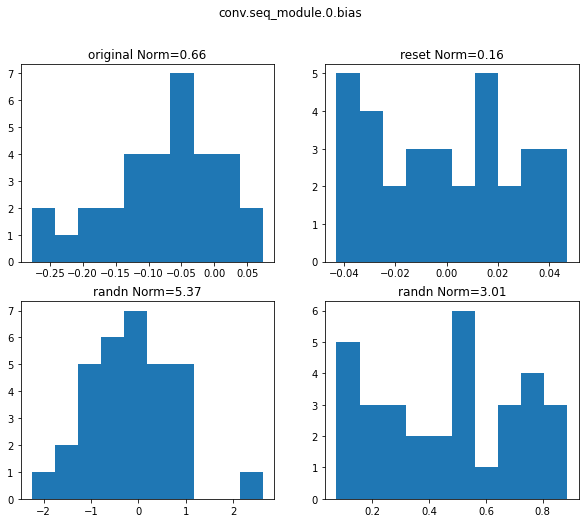

In [59]:
model_name = 'deepspeech2'
layer_name = 'conv.seq_module.0.bias'
compare_weight_initializations(model_name, layer_name)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.p

Randomly 'resetting' the network parameters...
Initializing 'random weights' the network parameters...
Initializing 'random weights' the network parameters...


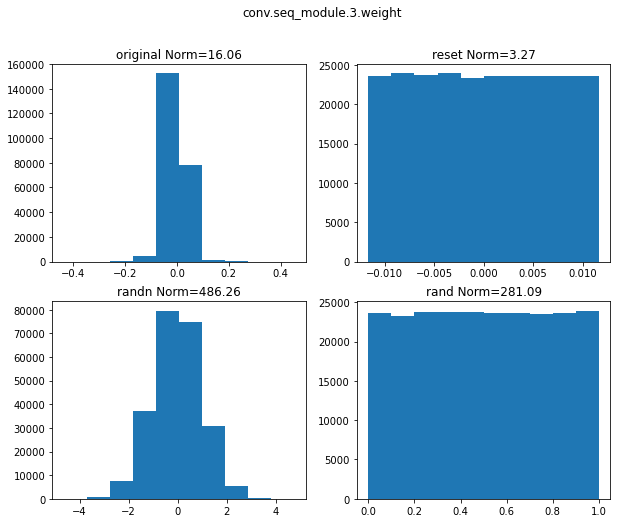

In [66]:
model_name = 'deepspeech2'
layer_name = 'conv.seq_module.3.weight'
compare_weight_initializations(model_name, layer_name)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.p

Randomly 'resetting' the network parameters...
Initializing 'random weights' the network parameters...
Initializing 'random weights' the network parameters...


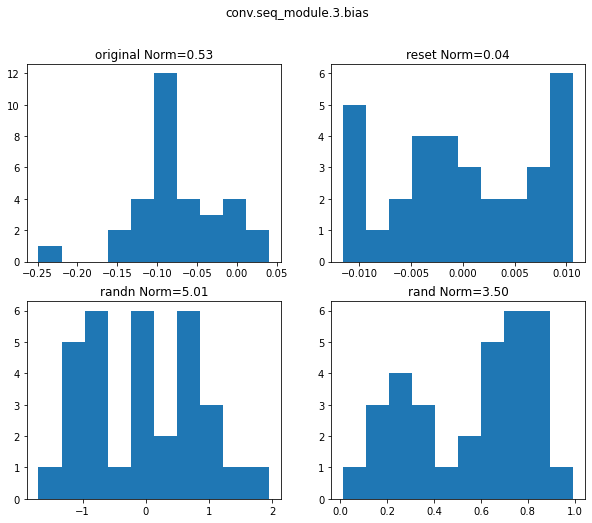

In [67]:
model_name = 'deepspeech2'
layer_name = 'conv.seq_module.3.bias'
compare_weight_initializations(model_name, layer_name)

### whisper_tiny..

In [81]:
dataloader = DataLoader()
model_name = 'whisper_tiny'
dnn_obj = dataloader.get_DNN_obj(model_name)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Loaded network from openai/whisper-tiny


In [82]:
dict([*dnn_obj.extractor.model.named_modules()])

{'': WhisperForConditionalGeneration(
   (model): WhisperModel(
     (encoder): WhisperEncoder(
       (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
       (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
       (embed_positions): Embedding(1500, 384)
       (layers): ModuleList(
         (0-3): 4 x WhisperEncoderLayer(
           (self_attn): WhisperAttention(
             (k_proj): Linear(in_features=384, out_features=384, bias=False)
             (v_proj): Linear(in_features=384, out_features=384, bias=True)
             (q_proj): Linear(in_features=384, out_features=384, bias=True)
             (out_proj): Linear(in_features=384, out_features=384, bias=True)
           )
           (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
           (activation_fn): GELUActivation()
           (fc1): Linear(in_features=384, out_features=1536, bias=True)
           (fc2): Linear(in_features=1536, out_features=384, bia

In [2]:
dataloader = DataLoader()
model_name = 'speech2text'
dnn_obj = dataloader.get_DNN_obj(model_name)
dict([*dnn_obj.extractor.model.named_modules()])

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.


{'': Speech2TextForConditionalGeneration(
   (model): Speech2TextModel(
     (encoder): Speech2TextEncoder(
       (conv): Conv1dSubsampler(
         (conv_layers): ModuleList(
           (0): Conv1d(80, 1024, kernel_size=(5,), stride=(2,), padding=(2,))
           (1): Conv1d(512, 2048, kernel_size=(5,), stride=(2,), padding=(2,))
         )
       )
       (embed_positions): Speech2TextSinusoidalPositionalEmbedding()
       (layers): ModuleList(
         (0-11): 12 x Speech2TextEncoderLayer(
           (self_attn): Speech2TextAttention(
             (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
             (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
           )
           (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
           (activation_fn): ReLU()
   

In [3]:
dataloader = DataLoader()
model_name = 'deepspeech2'
dnn_obj = dataloader.get_DNN_obj(model_name)
dict([*dnn_obj.extractor.model.named_modules()])

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.


/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (WordErrorRate). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchmetrics/utilities/prints.p

{'': DeepSpeech(
   (conv): MaskConv(
     (seq_module): Sequential(
       (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5))
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): Hardtanh(min_val=0, max_val=20, inplace=True)
       (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5))
       (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (5): Hardtanh(min_val=0, max_val=20, inplace=True)
     )
   )
   (rnns): Sequential(
     (0): BatchRNN(
       (rnn): LSTM(1312, 1024, bidirectional=True)
     )
     (1): BatchRNN(
       (batch_norm): SequenceWise (
       BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
       (rnn): LSTM(1024, 1024, bidirectional=True)
     )
     (2): BatchRNN(
       (batch_norm): SequenceWise (
       BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
       

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Loaded network from openai/whisper-tiny
Randomly 'resetting' the network parameters...
Initializing 'random weights' the network parameters...
Initializing 'random weights' the network parameters...


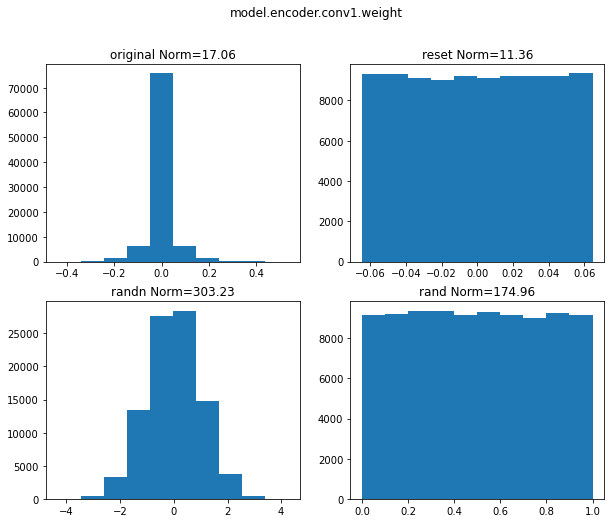

In [73]:
model_name = 'whisper_tiny'
layer_name = 'model.encoder.conv1.weight'
compare_weight_initializations(model_name, layer_name)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Loaded network from openai/whisper-tiny
Randomly 'resetting' the network parameters...
Initializing 'random weights' the network parameters...
Initializing 'random weights' the network parameters...


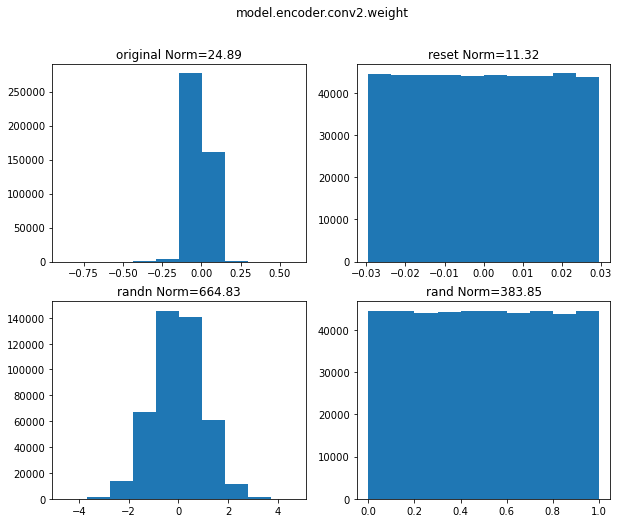

In [74]:
model_name = 'whisper_tiny'
layer_name = 'model.encoder.conv2.weight'
compare_weight_initializations(model_name, layer_name)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Loaded network from openai/whisper-tiny
Randomly 'resetting' the network parameters...
Initializing 'random weights' the network parameters...
Initializing 'random weights' the network parameters...


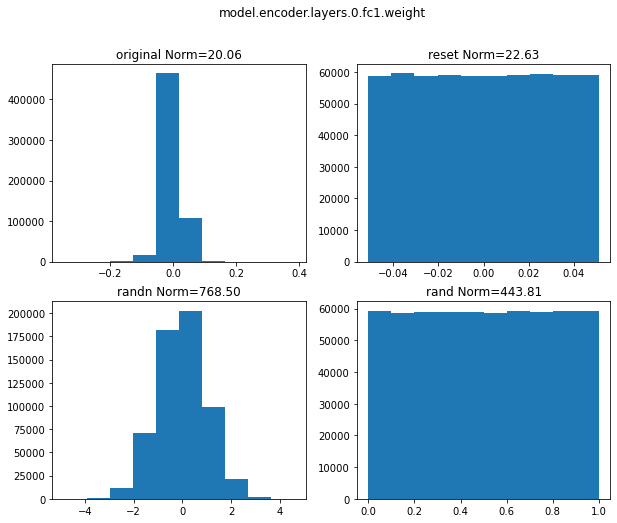

In [83]:
model_name = 'whisper_tiny'
layer_name = 'model.encoder.layers.0.fc1.weight'
compare_weight_initializations(model_name, layer_name)

### wav2letter

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Loading from checkpoint: /depot/jgmakin/data/auditory_cortex/results/pretrained_weights/wav2letter_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt
Randomly 'resetting' the network parameters...
Initializing 'random weights' the network parameters...
Initializing 'random weights' the network parameters...


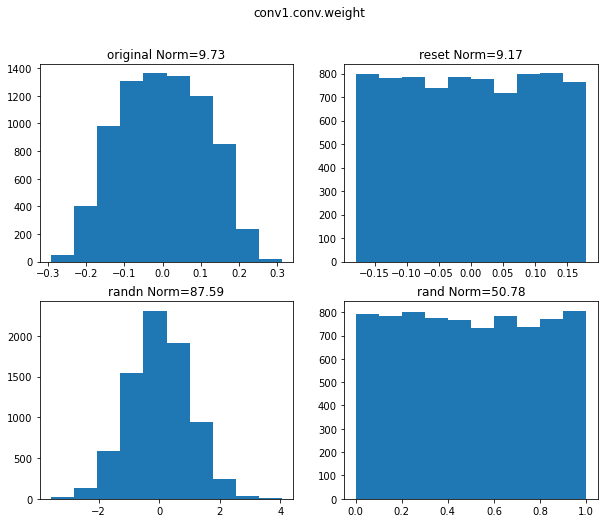

In [78]:
model_name = 'wav2letter_modified'
layer_name = 'conv1.conv.weight'
compare_weight_initializations(model_name, layer_name)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Loading from checkpoint: /depot/jgmakin/data/auditory_cortex/results/pretrained_weights/wav2letter_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt
Randomly 'resetting' the network parameters...
Initializing 'random weights' the network parameters...
Initializing 'random weights' the network parameters...


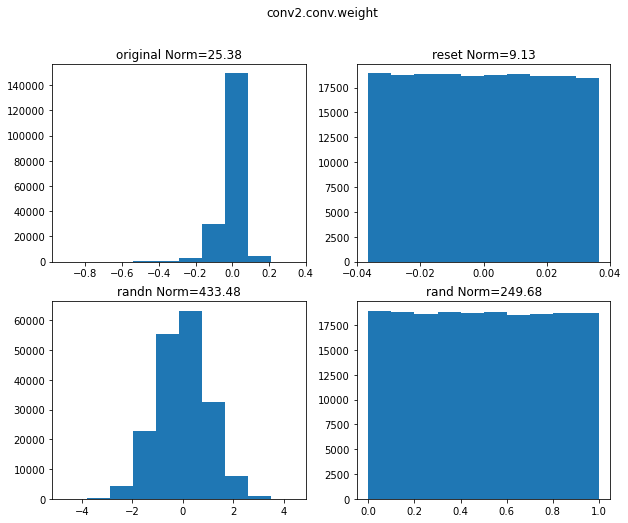

In [79]:
model_name = 'wav2letter_modified'
layer_name = 'conv2.conv.weight'
compare_weight_initializations(model_name, layer_name)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Loading from checkpoint: /depot/jgmakin/data/auditory_cortex/results/pretrained_weights/wav2letter_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt
Randomly 'resetting' the network parameters...
Initializing 'random weights' the network parameters...
Initializing 'random weights' the network parameters...


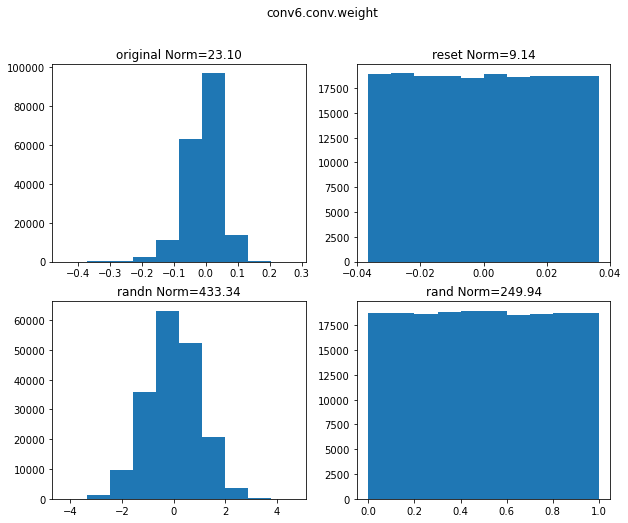

In [80]:
model_name = 'wav2letter_modified'
layer_name = 'conv6.conv.weight'
compare_weight_initializations(model_name, layer_name)

In [75]:
dataloader = DataLoader()
model_name = 'wav2letter_modified'
dnn_obj = dataloader.get_DNN_obj(model_name)

Using default normalizer file...
Creating normalizer object from: modified_bins_normalizer.csv
Reading existing dataframe.
Loading from checkpoint: /depot/jgmakin/data/auditory_cortex/results/pretrained_weights/wav2letter_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt


In [76]:
dict([*dnn_obj.extractor.model.named_modules()])

{'': Wav2LetterRF(
   (loss_fn): CTCLoss()
   (conv1): conv_block(
     (conv): Conv1d(1, 250, kernel_size=(31,), stride=(20,), padding=(15,))
     (batch_norm): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (activation): ReLU()
     (dropout): Dropout(p=0.2, inplace=False)
   )
   (conv2): conv_block(
     (conv): Conv1d(250, 250, kernel_size=(3,), stride=(2,), padding=(1,))
     (batch_norm): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (activation): ReLU()
     (dropout): Dropout(p=0.2, inplace=False)
   )
   (conv3): conv_block(
     (conv): Conv1d(250, 250, kernel_size=(3,), stride=(2,), padding=(1,))
     (batch_norm): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (activation): ReLU()
     (dropout): Dropout(p=0.2, inplace=False)
   )
   (conv4): conv_block(
     (conv): Conv1d(250, 250, kernel_size=(3,), stride=(2,), padding=(1,))
     (batch_norm): BatchNorm1

In [77]:
dnn_obj.extractor.model.state_dict()['conv1.conv.weight']

tensor([[[ 0.0988, -0.0759, -0.0886,  ..., -0.1924,  0.0688, -0.0297]],

        [[ 0.0761,  0.0672, -0.1215,  ..., -0.0090, -0.1098,  0.1285]],

        [[ 0.0563,  0.1171, -0.1071,  ...,  0.0575, -0.1729, -0.0126]],

        ...,

        [[-0.0856, -0.0526, -0.0120,  ..., -0.0391, -0.1411, -0.0246]],

        [[ 0.1316,  0.1628, -0.0520,  ...,  0.1808,  0.1166,  0.1614]],

        [[-0.2292,  0.0922, -0.0809,  ...,  0.0883, -0.1209,  0.1619]]],
       device='cuda:0')